# Chapter 15: Let’s Do Development

Paolo Perrotta, Programming Machine Learning: From Coding to Deep Learning (2020)

## Preparing Data

In [1]:
import numpy as np
import gzip
import struct


def load_images(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Read the header information into a bunch of variables:
        _ignored, n_images, columns, rows = struct.unpack('>IIII', f.read(16))
        # Read all the pixels into a NumPy array:
        all_pixels = np.frombuffer(f.read(), dtype=np.uint8)
        # Reshape the pixels into a matrix where each line is an image:
        return all_pixels.reshape(n_images, columns * rows)

    
def load_labels(filename):
    # Open and unzip the file of images:
    with gzip.open(filename, 'rb') as f:
        # Skip the header bytes:
        f.read(8)
        # Read all the labels into a list:
        all_labels = f.read()
        # Reshape the list of labels into a one-column matrix:
        return np.frombuffer(all_labels, dtype=np.uint8).reshape(-1, 1)


def one_hot_encode(Y):
    n_labels = Y.shape[0]
    n_classes = 10
    encoded_Y = np.zeros((n_labels, n_classes))
    for i in range(n_labels):
        label = Y[i]
        encoded_Y[i][label] = 1
    return encoded_Y

In [2]:
# Prepare MNIST labels.

# 60K labels, each a single digit from 0 to 9
Y_train_unencoded = load_labels("./mnist/train-labels-idx1-ubyte.gz") #注意檔案路徑是否正確

# Y_train: 60K labels, each consisting of 10 one-hot encoded elements
Y_train = one_hot_encode(Y_train_unencoded)

# Y_validation/Y_test: 5K/5K labels, each a single digit from 0 to 9
Y_test_all = load_labels("./mnist/t10k-labels-idx1-ubyte.gz") #注意檔案路徑是否正確
Y_validation, Y_test = np.split(Y_test_all, 2)

In [3]:
# Prepare non-standardized MNIST inputs.

# X_train/X_validation/X_test: 60K/5K/5K images
# Each image has 784 elements (28 * 28 pixels)
X_train_non_standardized = load_images("./mnist/train-images-idx3-ubyte.gz") #注意檔案路徑是否正確
X_test_all_non_standardized = load_images("./mnist/t10k-images-idx3-ubyte.gz") #注意檔案路徑是否正確
X_validation_non_standardized, X_test_non_standardized = np.split(X_test_all_non_standardized, 2)

In [4]:
# Prepare standardized MNIST inputs.

def standardize(training_set, test_set):
    average = np.average(training_set)
    standard_deviation = np.std(training_set)
    training_set_standardized = (training_set - average) / standard_deviation
    test_set_standardized = (test_set - average) / standard_deviation
    return (training_set_standardized, test_set_standardized)


# X_train/X_validation/X_test: 60K/5K/5K images
# Each image has 784 elements (28 * 28 pixels)
X_train_raw = load_images("../data/mnist/train-images-idx3-ubyte.gz") #注意檔案路徑是否正確
X_test_raw = load_images("../data/mnist/t10k-images-idx3-ubyte.gz") #注意檔案路徑是否正確
X_train, X_test_all = standardize(X_train_raw, X_test_raw)
X_validation, X_test = np.split(X_test_all, 2)

In [5]:
# The neural network:

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [6]:
def sigmoid_gradient(sigmoid):
    return np.multiply(sigmoid, (1 - sigmoid))

In [7]:
def softmax(logits):
    exponentials = np.exp(logits)
    return exponentials / np.sum(exponentials, axis=1).reshape(-1, 1)

def loss(Y, y_hat):
    return -np.sum(Y * np.log(y_hat)) / Y.shape[0]

In [8]:
def prepend_bias(X):
    return np.insert(X, 0, 1, axis=1)

def forward(X, w1, w2):
    h = sigmoid(np.matmul(prepend_bias(X), w1))
    y_hat = softmax(np.matmul(prepend_bias(h), w2))
    return (y_hat, h)

In [9]:
def back(X, Y, y_hat, w2, h):
    w2_gradient = np.matmul(prepend_bias(h).T, (y_hat - Y)) / X.shape[0]
    w1_gradient = np.matmul(prepend_bias(X).T, np.matmul(y_hat - Y, w2[1:].T)* sigmoid_gradient(h)) / X.shape[0]
    return (w1_gradient, w2_gradient)


def classify(X, w1, w2):
    y_hat, _ = forward(X, w1, w2)
    labels = np.argmax(y_hat, axis=1)
    return labels.reshape(-1, 1)

In [10]:
def initialize_weights(n_input_variables, n_hidden_nodes, n_classes):
    w1_rows = n_input_variables + 1
    w1 = np.random.randn(w1_rows, n_hidden_nodes) * np.sqrt(1 / w1_rows)

    w2_rows = n_hidden_nodes + 1
    w2 = np.random.randn(w2_rows, n_classes) * np.sqrt(1 / w2_rows)

    return (w1, w2)


def prepare_batches(X_train, Y_train, batch_size):
    x_batches = []
    y_batches = []
    n_examples = X_train.shape[0]
    for batch in range(0, n_examples, batch_size):
        batch_end = batch + batch_size
        x_batches.append(X_train[batch:batch_end])
        y_batches.append(Y_train[batch:batch_end])
    return x_batches, y_batches


def report(epoch, batch, X_train, Y_train, X_test, Y_test, w1, w2):
    y_hat, _ = forward(X_train, w1, w2)
    training_loss = loss(Y_train, y_hat)
    classifications = classify(X_test, w1, w2)
    accuracy = np.average(classifications == Y_test) * 100.0
    if batch % 60 == 0:
        print("%5d-%d > Loss: %.8f, Accuracy: %.2f%%" %(epoch, batch, training_loss, accuracy))
    
def train(X_train, Y_train, X_test, Y_test, n_hidden_nodes, epochs, batch_size, lr):
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]

    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    x_batches, y_batches = prepare_batches(X_train, Y_train, batch_size)
    for epoch in range(epochs):
        for batch in range(len(x_batches)):
            y_hat, h = forward(x_batches[batch], w1, w2)
            w1_gradient, w2_gradient = back(x_batches[batch], y_batches[batch], y_hat, w2, h)
            w1 = w1 - (w1_gradient * lr)
            w2 = w2 - (w2_gradient * lr)
            report(epoch, batch, X_train, Y_train, X_test, Y_test, w1, w2)
    return (w1, w2)

In [11]:
print("Regular MNIST:")
train(X_train_non_standardized, Y_train, X_validation_non_standardized, Y_validation,
      n_hidden_nodes=200, epochs=2, batch_size=60, lr=0.1)

print("Standardized MNIST:")
train(X_train, Y_train, X_validation, Y_validation,
      n_hidden_nodes=200, epochs=2, batch_size=60, lr=0.1)

Regular MNIST:


<ipython-input-5-b2c7aad6cd1d>:6: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


    0-0 > Loss: 2.37650249, Accuracy: 10.94%
    0-60 > Loss: 0.90736720, Accuracy: 74.00%
    0-120 > Loss: 0.67966508, Accuracy: 78.36%
    0-180 > Loss: 0.63896304, Accuracy: 81.16%
    0-240 > Loss: 0.61871490, Accuracy: 83.12%
    0-300 > Loss: 0.60742837, Accuracy: 80.10%
    0-360 > Loss: 0.52891224, Accuracy: 83.58%
    0-420 > Loss: 0.59096331, Accuracy: 81.60%
    0-480 > Loss: 0.49844581, Accuracy: 84.34%
    0-540 > Loss: 0.52110999, Accuracy: 83.62%
    0-600 > Loss: 0.50341176, Accuracy: 83.30%
    0-660 > Loss: 0.47282635, Accuracy: 84.56%
    0-720 > Loss: 0.52318060, Accuracy: 83.14%
    0-780 > Loss: 0.47368982, Accuracy: 84.38%
    0-840 > Loss: 0.48131245, Accuracy: 85.66%
    0-900 > Loss: 0.45601497, Accuracy: 84.76%
    0-960 > Loss: 0.50352819, Accuracy: 83.78%
    1-0 > Loss: 0.46574080, Accuracy: 84.70%
    1-60 > Loss: 0.46141429, Accuracy: 84.90%
    1-120 > Loss: 0.47638184, Accuracy: 84.14%
    1-180 > Loss: 0.47724376, Accuracy: 83.50%
    1-240 > Loss: 0

(array([[ 0.02004785,  0.01490182, -0.02425929, ...,  0.01535862,
          0.0628912 ,  0.03688893],
        [-0.04800978,  0.02902872,  0.01838625, ...,  0.04489642,
          0.0317798 , -0.02459626],
        [-0.00940663,  0.00785188,  0.06757994, ..., -0.01781008,
          0.03329511,  0.00848511],
        ...,
        [-0.04702034,  0.00775589, -0.00609494, ..., -0.016192  ,
          0.02181002, -0.00787742],
        [-0.02800828,  0.0798001 , -0.00055209, ...,  0.04330556,
         -0.00203644,  0.04445824],
        [ 0.02827284, -0.01745794,  0.02166116, ...,  0.05571084,
         -0.01573183, -0.03142068]]),
 array([[-0.11292168, -0.0438    , -0.05477872, ..., -0.0149589 ,
          0.09839213, -0.04658653],
        [-0.07461564,  0.09069232, -0.05308991, ...,  0.35527375,
         -0.14475129, -0.24813961],
        [ 0.20157404,  0.12158986,  0.25001823, ..., -0.35630603,
         -0.06801996, -0.18845692],
        ...,
        [ 0.34474861,  0.02292439, -0.28709883, ...,  

## Tuning Hyperparameters

In [12]:
# Compare utility:

%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns


# This train() replaces the previous one, and it differs from it in a few ways:
#
# * it runs for a specified time, rather than a specified number of epochs;
# * it runs quietly instead of reporting the loss and accuracy at each step;
# * at each step it stores the loss and time passed, and finally returns those
#   histories to the caller;
# * it also returns the number of training epochs and the total number of
#   gradient descent steps.

def train(X_train, Y_train, X_validation, Y_validation,
          n_hidden_nodes, lr, batch_size, time_in_seconds):
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]

    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    x_batches, y_batches = prepare_batches(X_train, Y_train, batch_size)

    start_time = time.time()
    times = []
    losses = []
    epochs = 0
    steps = 0
    while True:
        batch = 0
        while (batch < len(x_batches)):
            training_classifications, _ = forward(X_train, w1, w2)
            training_loss = loss(Y_train, training_classifications)
            times.append(np.floor(time.time() - start_time))
            losses.append(training_loss)

            time_passed = time.time() - start_time
            if time_passed > time_in_seconds:
                return (times, losses, epochs, steps)

            y_hat, h = forward(x_batches[batch], w1, w2)
            w1_gradient, w2_gradient = back(x_batches[batch], y_batches[batch], y_hat, w2, h)
            w1 = w1 - (w1_gradient * lr)
            w2 = w2 - (w2_gradient * lr)

            batch += 1
            steps += 1
        epochs += 1


# Train the network with the specified configuration
def configuration(n_hidden_nodes, batch_size, lr, time_in_seconds, label, color, linestyle):
    print("Training:", label)
    times, losses, epochs, steps = train(X_train, Y_train, X_validation, Y_validation,
                                         n_hidden_nodes=n_hidden_nodes,
                                         batch_size=batch_size,
                                         lr=lr,
                                         time_in_seconds=time_in_seconds)
    print("  Loss: %.8f (%d epochs completed, %d total steps)" % (losses[-1], epochs, steps))
    plt.plot(times, losses, label=label, color=color, linestyle=linestyle)


# Show a chart comparing the loss histories for all configurations
def show_results():
    sns.set()
    plt.xlabel("Seconds")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

### Tuning the Number of Hidden Nodes

Training: h=10
  Loss: 0.31081695 (6 epochs completed, 2919 total steps)
Training: h=100
  Loss: 0.21858452 (3 epochs completed, 1736 total steps)
Training: h=400
  Loss: 0.29646288 (1 epochs completed, 784 total steps)
Training: h=1000
  Loss: 0.35594291 (0 epochs completed, 354 total steps)


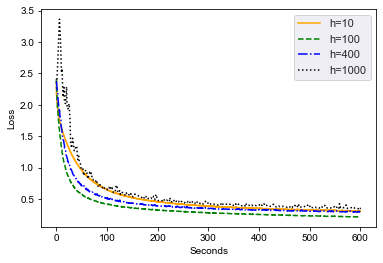

In [13]:
batch = 128
lr = 0.1
time_in_seconds = 60 * 10
configuration(n_hidden_nodes=10, batch_size=batch,
              lr=lr, time_in_seconds=time_in_seconds,
              label="h=10", color='orange', linestyle='-')
configuration(n_hidden_nodes=100, batch_size=batch,
              lr=lr, time_in_seconds=time_in_seconds,
              label="h=100", color='green', linestyle='--')
configuration(n_hidden_nodes=400, batch_size=batch,
              lr=lr, time_in_seconds=time_in_seconds,
              label="h=400", color='blue', linestyle='-.')
configuration(n_hidden_nodes=1000, batch_size=batch,
              lr=lr, time_in_seconds=time_in_seconds,
              label="h=1000", color='black', linestyle=':')
show_results()

### Tuning the Learning Rate

Training: lr=0.001
  Loss: 1.63098072 (3 epochs completed, 1825 total steps)
Training: lr=0.01
  Loss: 0.51050912 (3 epochs completed, 1823 total steps)
Training: lr=0.1
  Loss: 0.21698184 (3 epochs completed, 1821 total steps)
Training: lr=1
  Loss: 0.06310118 (3 epochs completed, 1812 total steps)


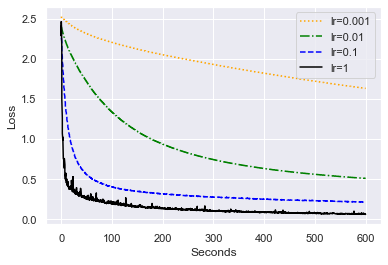

In [14]:
hidden = 100
batch = 128
time_in_seconds = 60 * 10
configuration(n_hidden_nodes=hidden, batch_size=batch,
              lr=0.001, time_in_seconds=time_in_seconds,
              label="lr=0.001", color='orange', linestyle=':')
configuration(n_hidden_nodes=hidden, batch_size=batch,
              lr=0.01, time_in_seconds=time_in_seconds,
              label="lr=0.01", color='green', linestyle='-.')
configuration(n_hidden_nodes=hidden, batch_size=batch,
              lr=0.1, time_in_seconds=time_in_seconds,
              label="lr=0.1", color='blue', linestyle='--')
configuration(n_hidden_nodes=hidden, batch_size=batch,
              lr=1, time_in_seconds=time_in_seconds,
              label="lr=1", color='black', linestyle='-')
show_results()

### Tuning the Batch Size

Training: batch_size=60000
  Loss: 0.16401598 (320 epochs completed, 320 total steps)
Training: batch_size=256
  Loss: 0.09217372 (3 epochs completed, 905 total steps)
Training: batch_size=128
  Loss: 0.10328703 (1 epochs completed, 908 total steps)
Training: batch_size=64
  Loss: 0.12802424 (0 epochs completed, 912 total steps)


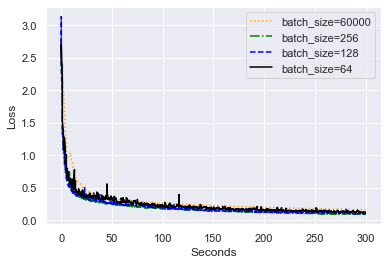

In [15]:
hidden = 100
lr = 1
time_in_seconds = 60 * 5
configuration(n_hidden_nodes=hidden, batch_size=60000,
              lr=lr, time_in_seconds=time_in_seconds,
              label="batch_size=60000", color='orange', linestyle=':')
configuration(n_hidden_nodes=hidden, batch_size=256,
              lr=lr, time_in_seconds=time_in_seconds,
              label="batch_size=256", color='green', linestyle='-.')
configuration(n_hidden_nodes=hidden, batch_size=128,
              lr=lr, time_in_seconds=time_in_seconds,
              label="batch_size=128", color='blue', linestyle='--')
configuration(n_hidden_nodes=hidden, batch_size=64,
              lr=lr, time_in_seconds=time_in_seconds,
              label="batch_size=64", color='black', linestyle='-')
show_results()

## The Final Test

In [16]:
# Remove all the instrumentation from the train() function:

def train(X_train, Y_train, X_test, Y_test, n_hidden_nodes,
          epochs, batch_size, lr):
    n_input_variables = X_train.shape[1]
    n_classes = Y_train.shape[1]

    w1, w2 = initialize_weights(n_input_variables, n_hidden_nodes, n_classes)
    x_batches, y_batches = prepare_batches(X_train, Y_train, batch_size)
    for epoch in range(epochs):
        for batch in range(len(x_batches)):
            y_hat, h = forward(x_batches[batch], w1, w2)
            w1_gradient, w2_gradient = back(x_batches[batch], y_batches[batch],
                                            y_hat, w2, h)
            w1 = w1 - (w1_gradient * lr)
            w2 = w2 - (w2_gradient * lr)
            report(epoch, batch, X_train, Y_train, X_test, Y_test, w1, w2)
    return (w1, w2)

In [17]:
train(X_train, Y_train, X_test, Y_test,
      n_hidden_nodes=100, epochs=10, batch_size=256, lr=1)
print("Done.")

    0-0 > Loss: 2.51126276, Accuracy: 23.72%
    0-60 > Loss: 0.33310378, Accuracy: 93.48%
    0-120 > Loss: 0.30845169, Accuracy: 93.60%
    0-180 > Loss: 0.23942956, Accuracy: 95.40%
    1-0 > Loss: 0.20253645, Accuracy: 95.98%
    1-60 > Loss: 0.17660872, Accuracy: 96.48%
    1-120 > Loss: 0.17063644, Accuracy: 96.62%
    1-180 > Loss: 0.15613097, Accuracy: 96.96%
    2-0 > Loss: 0.14175469, Accuracy: 97.18%
    2-60 > Loss: 0.12915326, Accuracy: 97.36%
    2-120 > Loss: 0.12378315, Accuracy: 97.46%
    2-180 > Loss: 0.11946919, Accuracy: 97.50%
    3-0 > Loss: 0.11162509, Accuracy: 97.62%
    3-60 > Loss: 0.10325359, Accuracy: 97.84%
    3-120 > Loss: 0.09893073, Accuracy: 97.88%
    3-180 > Loss: 0.09740125, Accuracy: 97.80%
    4-0 > Loss: 0.09252305, Accuracy: 97.92%
    4-60 > Loss: 0.08625310, Accuracy: 98.02%
    4-120 > Loss: 0.08262424, Accuracy: 98.14%
    4-180 > Loss: 0.08198647, Accuracy: 98.06%
    5-0 > Loss: 0.07886094, Accuracy: 98.14%
    5-60 > Loss: 0.07383451, A